In [4]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad

mpl.rcParams['font.family'] = 'serif'


#
# Helper Functions
#


def dn(x):
    # ''' Probability density function of standard normal random variable x.'''
    return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)


def n(d):
    # ''' Cumulative density function of standard normal random variable x. '''
    return quad(lambda x: dn(x), -20, d, limit=50)[0]


def d1f(st, k, t, m, r, sigma):
    # ''' Black-Scholes-Merton d1 function.
    # Parameters see e.g. BSM_call_value function. '''
    d1 = (math.log(st / k) + (r + 0.5 * sigma ** 2)
          * (m - t)) / (sigma * math.sqrt(m - t))
    return d1


def bsm_call_value(st, k, t, m, r, sigma):
    """
    Calculates Black-Scholes-Merton European call option value.
    Parameters
    ==========
    st: float
    stock/index level at time t
    k: float
    strike price
    t: float
    valuation date
    m: float
    date of maturity/time-to-maturity if t = 0; T > t
    r: float
    constant, risk-less short rate
    sigma: float volatility
    Returns
    =======
    call_value: float
    European call present value at t
    """
    d1 = d1f(st, k, t, m, r, sigma)
    d2 = d1 - sigma * math.sqrt(m - t)
    call_value = st * n(d1) - math.exp(-r * (m - t)) * k * n(d2)
    return call_value


def bsm_put_value(st, k, t, m, r, sigma):
    """ Calculates Black-Scholes-Merton European put option value.
    Parameters
    put_value: float
    European put present value at t
    """
    put_value = bsm_call_value(st, k, t, m, r, sigma) - st + math.exp(-r * (m - t)) * k
    return put_value

# Option class

class BsmOption:
    def __init__(self, st, k, t, m, r, sigma):
        self.St = st
        self.K = k
        self.t = t
        self.T = m
        self.r = r
        self.sigma = sigma

    #
    # Valuation Functions
    #

    def bsm_call_value(self):
        """
        Calculates Black-Scholes-Merton European call option value.
        call_value: float
        European call present value at t
        """
        d1 = d1f(self.St, self.K, self.t, self.T, self.r, self.sigma)
        d2 = d1 - self.sigma * math.sqrt(self.T - self.t)
        call_value = self.St * n(d1) - math.exp(-self.r * (self.T - self.t)) * self.K * n(d2)
        return call_value

    def bsm_put_value(self):
        """
        Calculates Black-Scholes-Merton European put option value.
        """
        put_value = self.bsm_call_value() - self.St + math.exp(-self.r * (self.T - self.t)) * self.K
        return put_value

    #
    # Plotting European Option Values
    #

    def plot_values(self, option_type="call"):
        """
        Plots European option values for different parameters c.p.
        """
        plt.figure(figsize=(10, 8.3))
        points = 100
        #
        # Model Parameters
        #
        """
        st = 100.0  # index level
        k = 100.0  # option strike
        t = 0.0  # valuation date
        m = 1.0  # maturity date
        r = 0.05  # risk-less short rate
        sigma = 0.2  # volatility
        """
        if option_type.lower() == "call":
            function = bsm_call_value
        elif option_type.lower() == "put":
            function = bsm_put_value
        else:
            print("Please choose either 'call' or 'put'")
            return
        
        # C(K) plot
        plt.subplot(221)
        klist = np.linspace(self.K - self.K/6, self.K + self.K/6, points)
        val_list = [function(self.St, K, self.t, self.T, self.r, self.sigma) for K in klist]
        plt.plot(klist, val_list)
        plt.grid()
        plt.xlabel('strike $K$')
        plt.ylabel('present value')
        # C(T) plot
        plt.subplot(222)
        valuation_dates = np.linspace(self.T - self.T/6, self.T + self.T/6, points)
        val_list = [function(self.St, self.K, self.t, T, self.r, self.sigma) for T in valuation_dates]
        plt.plot(valuation_dates, val_list)
        plt.grid(True)
        plt.xlabel('maturity $T$')
        # C(r) plot
        plt.subplot(223)
        short_rate_list = np.linspace(self.r - self.r/6, self.r + self.r/6, points)
        val_list = [function(self.St, self.K, self.t, self.T, r, self.sigma) for r in short_rate_list]
        plt.plot(valuation_dates, val_list)
        plt.grid(True)
        plt.xlabel('short rate $r$')
        plt.ylabel('present value')
        plt.axis('tight')
        # C(sigma) plot
        plt.subplot(224)
        sigmas_list = np.linspace(self.sigma - self.sigma/6, self.sigma + self.sigma/6, points)
        val_list = [function(self.St, self.K, self.t, self.T, self.r, sigma) for sigma in sigmas_list]
        plt.plot(sigmas_list, val_list)
        plt.grid(True)
        plt.xlabel('volatility $sigma$')
        plt.tight_layout()


In [5]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from Options_pricing.BSM_pricing import d1f, n, dn
mpl.rcParams['font.family'] = 'serif'

#
# Functions for Greeks
#


def bsm_delta(st, k, t, m, r, sigma):
    """
    Black-Scholes-Merton DELTA of European call option.
    Parameters
    ==========
    st: float
    stock/index level at time t
    k: float
    strike price
    t: float
    valuation date
    m: float
    date of maturity/time-to-maturity if t = 0; T > t
    r: float
    constant, risk-less short rate
    sigma: float volatility
    Returns
    =======
    delta: float
    European call option DELTA
    """
    d1 = d1f(st, k, t, m, r, sigma)
    delta = n(d1)
    return delta


def bsm_gamma(st, k, t, m, r, sigma):
    """ Black-Scholes-Merton GAMMA of European call option.
    Parameters
    ==========
    st: float
    stock/index level at time t
    k: float
    strike price
    t: float
    valuation date
    m: float
    date of maturity/time-to-maturity if t = 0; T > t
    r: float
    constant, risk-less short rate
    sigma: float volatility
    Returns
    =======
    gamma: float
    European call option GAMMA
    """
    d1 = d1f(st, k, t, m, r, sigma)
    gamma = dn(d1) / (st * sigma * math.sqrt(m - t))
    return gamma


def bsm_theta(st, k, t, m, r, sigma):
    """
    Black-Scholes-Merton THETA of European call option.
    Parameters
    ==========
    st: float
    stock/index level at time t
    k: float
    strike price
    t: float
    valuation date
    m: float
    date of maturity/time-to-maturity if t = 0; T > t
    r: float
    constant, risk-less short rate
    sigma: float volatility
    Returns
    =======
    theta: float
    European call option THETA
    """
    d1 = d1f(st, k, t, m, r, sigma)
    d2 = d1 - sigma * math.sqrt(m - t)
    theta = -(st * dn(d1) * sigma / (2 * math.sqrt(m - t))
              + r * k * math.exp(-r * (m - t)) * n(d2))
    return theta


def bsm_rho(st, k, t, m, r, sigma):
    """
    Black-Scholes-Merton RHO of European call option.
    Parameters
    ==========
    st: float
    stock/index level at time t
    k: float
    strike price
    t: float
    valuation date
    m: float
    date of maturity/time-to-maturity if t = 0; T > t
    r: float
    constant, risk-less short rate
    sigma: float volatility
    Returns
    =======
    rho: float
    European call option RHO
    """
    d1 = d1f(st, k, t, m, r, sigma)
    d2 = d1 - sigma * math.sqrt(m - t)
    rho = k * (m - t) * math.exp(-r * (m - t)) * n(d2)
    return rho


def bsm_vega(st, k, t, m, r, sigma):
    """
    Black-Scholes-Merton VEGA of European call option.
    Parameters
    ==========
    st: float
    stock/index level at time t
    k: float
    strike price
    t: float
    valuation date
    m: float
    date of maturity/time-to-maturity if t = 0; T > t
    r: float
    constant, risk-less short rate
    sigma: float volatility
    Returns
    =======
    vega: float
    European call option VEGA
    """
    d1 = d1f(st, k, t, m, r, sigma)
    vega = st * dn(d1) * math.sqrt(m - t)
    return vega


# Option Class

class OptionGreeks:
    def __init__(self, st, k, t, m, r, sigma):
        self.St = st
        self.K = k
        self.t = t
        self.T = m
        self.r = r
        self.sigma = sigma

    def delta(self):
        """ Black-Scholes-Merton DELTA of European call option.
        delta: float
        European call option DELTA
        """
        d1 = d1f(self.St, self.K, self.t, self.T, self.r, self.sigma)
        delta = n(d1)
        return delta

    def gamma(self):
        """ Black-Scholes-Merton GAMMA of European call option.
        gamma: float
        European call option GAMMA
        """
        d1 = d1f(self.St, self.K, self.t, self.T, self.r, self.sigma)
        gamma = dn(d1) / (self.St * self.sigma * math.sqrt(self.T - self.t))
        return gamma

    def theta(self):
        """ Black-Scholes-Merton THETA of European call option.
        theta: float
        European call option THETA
        """
        d1 = d1f(self.St, self.K, self.t, self.T, self.r, self.sigma)
        d2 = d1 - self.sigma * math.sqrt(self.T - self.t)
        theta = -(self.St * dn(d1) * self.sigma / (2 * math.sqrt(self.T - self.t)) + self.r * self.K *
                  math.exp(-self.r * (self.T - self.t)) * n(d2))
        return theta

    def rho(self):
        """ Black-Scholes-Merton RHO of European call option.
        rho: float
        European call option RHO
        """
        d1 = d1f(self.St, self.K, self.t, self.T, self.r, self.sigma)
        d2 = d1 - self.sigma * math.sqrt(self.T - self.t)
        rho = self.K * (self.T - self.t) * math.exp(-self.r * (self.T - self.t)) * n(d2)
        return rho

    def vega(self):
        """ Black-Scholes-Merton VEGA of European call option.
        vega: float
        European call option VEGA
        """
        d1 = d1f(self.St, self.K, self.t, self.T, self.r, self.sigma)
        vega = self.St * dn(d1) * math.sqrt(self.T - self.t)
        return vega
    #
    # Plotting the Greeks
    #

    def plot_greeks(self, greek):
        if greek.lower() == "delta":
            function = bsm_delta
        elif greek.lower() == "gamma":
            function = bsm_gamma
        elif greek.lower() == "rho":
            function = bsm_rho
        elif greek.lower() == "theta":
            function = bsm_theta
        elif greek.lower() == "vega":
            function = bsm_vega
        else:
            print("please choose from : \n-delta\n-gamma\n-rho\n-theta\n-vega")
            return

        # Greek Calculations
        valuation_dates = np.linspace(0.01, 1, 25)
        strikes_range = np.linspace(80, 120, 25)
        values_matrix = np.zeros((len(valuation_dates), len(strikes_range)), dtype=np.float)
        for j in range(len(strikes_range)):
            for i in range(len(valuation_dates)):
                values_matrix[i, j] = function(self.St, strikes_range[j], self.t, valuation_dates[i], self.r, self.sigma)
        # 3D Plotting
        x, y = np.meshgrid(strikes_range, valuation_dates)
        fig = plt.figure(figsize=(9, 5))
        plot = p3.Axes3D(fig)
        plot.plot_wireframe(x, y, values_matrix)
        plot.set_xlabel('strike $K$')
        plot.set_ylabel('maturity $T$')
        plot.set_zlabel('%s(K, T)' % greek)


In [6]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Options_pricing.BSM_pricing import bsm_call_value
mpl.rcParams['font.family'] = 'serif'


def crr_option_value(s0, k, m, r, sigma, option_type='call', step=4):
    """ Cox-Ross-Rubinstein European option valuation.
    Parameters
    ==========
    s0: float
    stock/index level at time 0
    k: float
    strike price
    m: float
    date of maturity
    r: float
    constant, risk-less short rate
    sigma: float volatility
    option_type: string
    either 'call' or 'put'
    step: int
    number of time intervals
    """
    # Time Parameters
    dt = m / step  # length of time interval
    df = math.exp(-r * dt)  # discount per interval
    # Binomial Parameters
    u = math.exp(sigma * math.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (math.exp(r * dt) - d) / (u - d)  # martingale branch probability
    # Array Initialization for Index Levels
    mu = np.arange(step + 1)
    mu = np.resize(mu, (step + 1, step + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    s = s0 * mu * md
    # Inner Values
    if option_type == 'call':
        value = np.maximum(s - k, 0)  # inner values for European call option
    else:
        value = np.maximum(k - s, 0)  # inner values for European put option
    z = 0
    for t in range(step - 1, -1, -1):  # backwards iteration
        value[0:step - z, t] = (q * value[0:step - z, t + 1]
                                + (1 - q) * value[1:step - z + 1, t + 1]) * df
        z += 1
    return value[0, 0]


def plot_convergence(mmin, mmax, step_size, S0, K, T, r, sigma):
    """
    Plots the CRR option values for increasing number of time
    intervals M against the Black-Scholes-Merton benchmark value.
    """
    bsm_benchmark = bsm_call_value(S0, K, 0, T, r, sigma)
    m = range(mmin, mmax, step_size)
    crr_values = [crr_option_value(S0, K, T, r, sigma, 'call', M) for M in m]
    plt.figure(figsize=(9, 5))
    plt.plot(m, crr_values, label='CRR values')
    plt.axhline(bsm_benchmark, color='r', ls='dashed', lw=1.5, label='BSM benchmark')
    plt.grid()
    plt.xlabel('# of binomial steps $M$')
    plt.ylabel('European call option value')
    plt.legend(loc=4)
    plt.xlim(0, mmax)


class CrrBinModel:
    def __init__(self, s0, k, m, r, sigma, option_type, step=4):
        self.S0 = s0
        self.K = k
        self.T = m
        self.r = r
        self.sigma = sigma
        self.option_type = option_type
        self.M = step

    def price(self):
        option_value = crr_option_value(self.S0, self.K, self.T, self.r, self.sigma, self.option_type, self.M)
        return option_value

    def convergence(self):
        plot_convergence(self.M-2, self.M+3, 1, self.S0, self.K, self.T, self.r, self.sigma)


In [7]:
st = 10.5  # index level
k = 11 # option strike
t = 0.0  # valuation date
m = 3.0  # maturity date
r = 0.01  # risk-less short rate
sigma = 0.0239  # volatility
call = BsmOption(st, k, t, m, r, sigma)

In [8]:
call.bsm_call_value()

0.10112262670259087

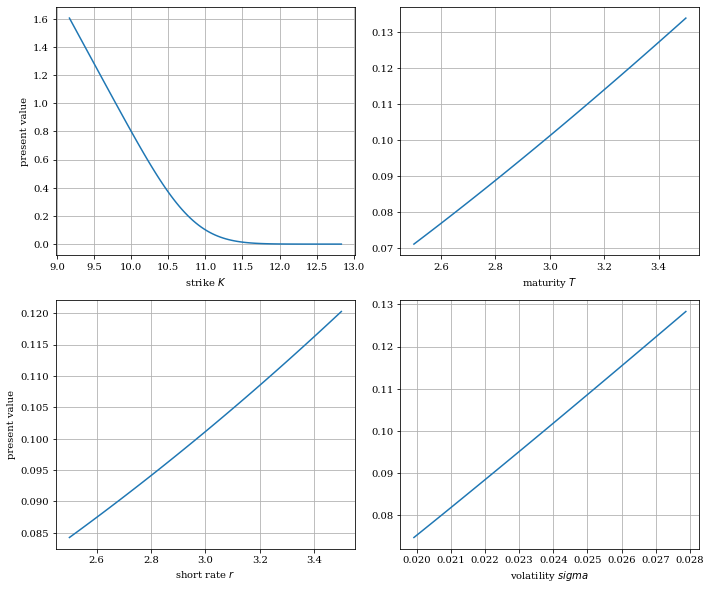

In [9]:
call.plot_values("call")

In [10]:
print(f"Call value with strike K = {k} and maturity in years T = {m} : "  + str(call.bsm_call_value()))
print(f"Put value with strike K = {k} and maturity in years T = {m} : "  + str(call.bsm_put_value()))

Call value with strike K = 11 and maturity in years T = 3.0 : 0.10112262670259087
Put value with strike K = 11 and maturity in years T = 3.0 : 0.27602349573617957


# Startegy simulation Framework

In [32]:
St = 10.56
t = 0
m = 1
r = 0.1
sigma = 0.0239

import numpy as np
import matplotlib.pyplot as plt
# input format {var_name = (option_type, postion(long,short), quantity, strike)}
class Combination():
    def __init__(self, **kwargs):
        self.kwargs = kwargs
    def value(self):
        portf = dict()
        x = np.linspace(St-St/3, St+St/3, 300)
        for _, params in self.kwargs.items():
            option = BsmOption(St, params[3], t, m, r, sigma)
            if params[0] == "call":
                portf[_] = option.bsm_call_value()
            elif params[0] == "put":
                portf[_] = option.bsm_put_value()
            else :
                print("invalid option type")
                return
        payoff = x
        ones = np.ones(len(x))
        for _, params in self.kwargs.items():
            if params[0] == "call" and params[1] == "long":
                ind = np.array([1 if i>params[3] else 0 for i in x])
                payoff += (x - params[3]*ones)*ind*params[2] - portf[_]
            elif params[0] == "call" and params[1] == "short":
                ind = np.array([1 if i>params[3] else 0 for i in x])
                payoff += (params[3]*ones - x)*ind*params[2] + portf[_]
            elif params[0] == "put" and params[1] == "long":
                ind = np.array([1 if i<params[3] else 0 for i in x])
                payoff += (params[3]*ones - x)*ind*params[2] - portf[_]
            elif params[0] == "put" and params[1] == "short":
                ind = np.array([1 if i<params[3] else 0 for i in x])
                payoff += (x - params[3]*ones)*ind*params[2] + portf[_]
        return(payoff)
        
    

In [72]:
strat1 = Combination(f=("put", "long", 1, 10), g=("call", "short", 1, 11), h = ("call", "long", 1, 12))

In [73]:
import matplotlib.pyplot as plt
x = np.linspace(St-St/3, St+St/3, 300)

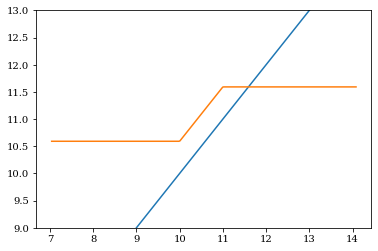

In [74]:
bottom = 9
top = 13
plt.ylim(bottom, top)
plt.plot(x,x)
plt.plot(x, strat1.value())

In [47]:
class portfolio:
    def __init__(self, *args):
        self.args = args
    def value(self):
        strat_payoff = np.zeros(len(x))
        for payoff in self.args:
            strat_payoff+=payoff.value()
        return(strat_payoff)

In [66]:
strat2 = Combination(f=("put", "long", 1, 9), g=("call", "short", 1, 12))

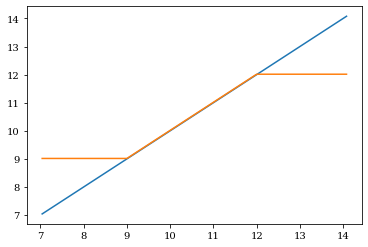

In [67]:
plt.plot(x,x)
plt.plot(x, strat2.value())

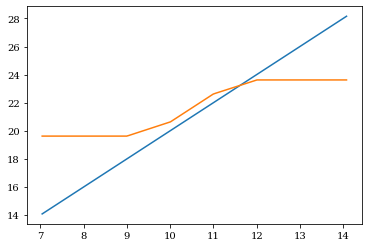

In [68]:
plt.plot(x,2*x)
plt.plot(x, portfolio(test, strat2).value())